# Introduction to MCMC


## Takeaways and objectives from this notebook
1. Monte Carlo may be ineffective in higher-dimensional models.  This motivates the Markov Chain MC approach.
2. Basic ideas behind MCMC and convergence conditions in a (simplified) discrete universe.
3. The detailed balance condition and the Metropolis method.
4. The Metropolis-Hastings generalization.

## Monte Carlo in linear regression with Laplace prior
Imagine that we would want to use a standard Monte Carlo method for a higher-dimensional problem, for example for a simple linear regression with with Laplace priors, an example inspired by [1].

$$\begin{array}{rcl}
  y &=& \beta_1*x+\beta_2+\epsilon\\
  \beta_1 &\sim& \text{Laplace}(0,1) \\
  \beta_1 &\sim& \text{Laplace}(0,1) \\
  \epsilon &\sim& {\cal N}(0,1) \\
\end{array}$$

Incidentally using [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) priors centered on zero (see below) is equivalent to imposing an $L_1$ penalty (regularization) on the linear regression.

In the following example, we don't use PyMC3 but rather write the likelihood and prior term explicitly.

## Specifying the model

In this case, we also demonstrate sampling from a distribution using transformations from a simpler distribution.  Instead of directly using `numpy.random.laplace`, we use `numpy.random.rand` to draw uniformly distributed numbers in $[0,1)$ and transform them into Laplace distributed numbers in the function `draw_betas`.

The function `prior` computes the prior probability of the samples that we have drawn by evaluating the [Laplace density](https://en.wikipedia.org/wiki/Laplace_distribution). Note that the normalizing constant is evaluated as well.

The function `likelihood` evaluates the data likelihood under the assumed noise model - again this function is properly normalized.

Finally the `model_posterior_unnorm` returns the product of the two functions above but isn't properly normalized because it's not divided by the model evidence.

Note that in PyMC3, all these functions are implemented in the logarithmic space already, meaning that the products become sums and the exponential terms disappear.

In [95]:
def draw_betas(n):
    # draw a from (-1/2, 1/2]
    u = -np.random.rand(n*2) + 0.5
    betas = - np.sign(u)*np.log(1-2*np.abs(u))
    return betas.reshape([n, 2])
    
def prior(betas):
    beta1_lk = 0.5 * np.exp(-np.abs(betas[0]-0.))
    beta2_lk = 0.5 * np.exp(-np.abs(betas[1]-0.))
    return beta1_lk * beta2_lk

def likelihood(betas, x, y):
    errors = y - (betas[0] * x + betas[1]) 
    return np.prod(np.exp(-0.5 * errors**2))

def model_posterior_unnorm(betas, x, y):
    return prior(betas) * likelihood(betas, x, y)

### Data
Manufacture data for our model for which we will compute the likelihood. We assume that the actual values are $\beta_1=2$ and $\beta_2=1$.

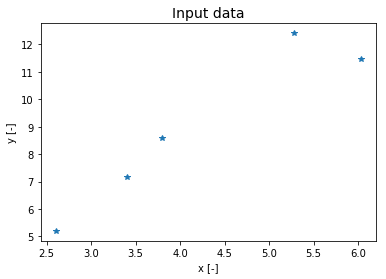

In [96]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_pts = 5

np.random.seed(124324)

# randomly generated x data - nothing to do with model
x = 2*np.random.randn(n_pts)+4

# y data are generated from model specified above with beta_1 = 2 and beta_2 = 1
y = 2*x+1+np.random.randn(n_pts)

plt.plot(x, y, '*')
plt.title('Input data', fontsize=14)
plt.xlabel('x [-]')
_ = plt.ylabel('y [-]')

In [97]:
np.random.seed(12345)

### Drawing $\beta_{1,2}$ candidates
We use our `draw_betas` function to obtain 15 samples from our prior and plot the resulting model in the context of our data.  Examine the 15 plots below.  Note that likelihood equal to zero happens whenever the likelihood underflows.

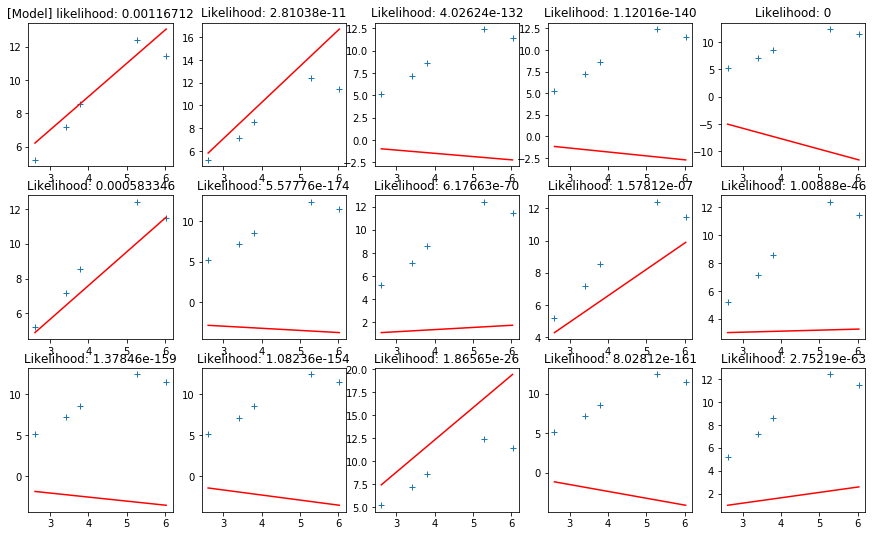

In [103]:
plt.figure(figsize=(15, 9))
plt.subplot(3,5,1)
plt.plot(x, y, '+')
plt.plot([min(x), max(x)], [2.*min(x)+1., 2.*max(x)+1.], 'r-')
plt.title('[Model] likelihood: %g' % model_posterior_unnorm([2., 1.], x, y))

for i, betas_i in enumerate(draw_betas(14)):
    plt.subplot(3, 5, i+2)
    plt.plot(x, y, '+')
    plt.plot([min(x), max(x)], [betas_i[0]*min(x)+betas_i[1], betas_i[0]*max(x)+betas_i[1]], 'r-')
    plt.title('Likelihood: %g' % model_posterior_unnorm(betas_i, x, y))

### Interpreting the plots
In general already for a two dimensional model, most of the samples have extremely small likelihood compared to the likelihood of the actual model, which is shown below.  This means we are sampling extremely low probability regions almost all the time.

## The posterior density
Since the problem is only two dimensional, we can plot the log-probability of the density easily.

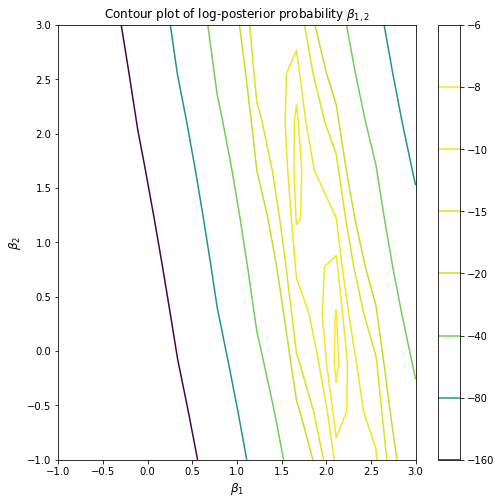

In [135]:
xg, yg = np.meshgrid(np.linspace(-1, 3, 10), np.linspace(-1, 3, 10))
zg = np.zeros_like(xg)
for i,j in np.ndindex(10,10):
    zg[i,j] = np.log(model_posterior_unnorm([xg[i,j], yg[i,j]], x, y))
plt.figure(figsize=(8, 8))
plt.contour(xg, yg, zg, levels=[-160, -80, -40, -20, -15,-10, -8, -6, -5, -4, -3])
plt.colorbar()
plt.title('Contour plot of log-posterior probability $\\beta_{1,2}$')
plt.xlabel('$\\beta_1$', fontsize=12)
plt.ylabel('$\\beta_2$', fontsize=12)
_ = plt.show()

## Note on relationship to L1 regularization

The likelihood of the model under the Laplacian prior can be written as:

$$p(\beta_1, \beta_2 \mid x, y) \propto \exp(-|\beta_1|)\exp(-|\beta_2|) \prod_{i=1}^n \exp \left (-0.5 (y_i - (\beta_1 x_i + \beta_2))^2 \right ).$$

Thus it's log-likelihood is

$$\log p(\beta_1, \beta_2 \mid {\bf x}, {\bf y}) = C + -|\beta_1| -|\beta_2| - \sum_{i=1}^n 0.5 (y_i - (\beta_1 x_i + \beta_2))^2,$$

where $C$ is a constant independent of $\beta_{1,2}$. Recall when we search for the MAP solution we wish to find the maximum of the above, which is equivalent to minimizing

$$J(\beta_1, \beta_2) = \frac{1}{2} \sum_{i=1}^n (y_i - (\beta_1 x_i + \beta_2))^2 + |\beta_1| + |\beta_2|.$$

The last expression is the objective for L1-regularization in linear regression, where we disregarded various constants and weights. We conclude that imposing zero-centered Laplacian priors on parameters is structurally equivalent to L1 regularization.

### Exercises

1. Generalize the equations above by considering different values of the parameter $b$ of the Laplace distribution in the priors.  Where do the $b$ terms appear in the equations and what is the effect of $b$ on the L1-regularization formulation?

2. Rewrite the model in logarithmic space (by modifying all functions to return log probabilities) and re-run the examples.

## Markov Chain Monte Carlo

### Sampling Markov Chains

The expectation above assumes that the draws of $\theta$ are **independent**. The limitation in using Monte Carlo sampling for Bayesian inference is that it is not usually feasible to make independent draws from the posterior distribution. 

The first "MC" in MCMC stands for **Markov chain**. A Markov chain is a **stochastic process**, an indexed set of random variables, where the value of a particular random variable in the set is dependent only on the random variable corresponding to the prevous index. This is a Markovian dependence structure:

$$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$

This conditioning specifies that the future depends on the current state, but not past states. Thus, the Markov chain wanders about the state space, remembering only where it has just been in the last time step. The collection of transition probabilities is sometimes called a *transition matrix* when dealing with discrete states, or more generally, a *transition kernel*.

MCMC allows us to generate samples from a particular posterior distribution as a Markov chain. The magic is that the resulting sample, even though it is dependent in this way, is indistinguishable from an independent sample from the true posterior.

## Why MCMC Works: Reversible Markov Chains

Markov chain Monte Carlo simulates a Markov chain for which some function of interest
(*e.g.* the joint distribution of the parameters of some model) is the unique, invariant limiting distribution. An invariant distribution with respect to some Markov chain with transition kernel $Pr(y \mid x)$ implies that:

$$\begin{gathered}
\begin{split}\int_x Pr(y \mid x) \pi(x) dx = \pi(y).\end{split}\notag\\\begin{split}\end{split}\notag
\end{gathered}$$

Invariance is guaranteed for any *reversible* Markov chain. Consider a Markov chain in reverse sequence:
$\{\theta^{(n)},\theta^{(n-1)},...,\theta^{(0)}\}$. This sequence is still Markovian, because:

$$\begin{gathered}
\begin{split}Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x,\theta^{(k+2)}=x_1,\ldots ) = Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x)\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Forward and reverse transition probabilities may be related through Bayes theorem:

$$\begin{gathered}
\begin{split}\end{split}\notag\end{gathered}$$

$$\begin{gathered}
\begin{split}\frac{Pr(\theta^{(k+1)}=x \mid \theta^{(k)}=y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Though not homogeneous in general, $\pi$ becomes homogeneous if:

-   $n \rightarrow \infty$

-   $\pi^{(i)}=\pi$ for some $i < k$

If this chain is homogeneous it is called reversible, because it satisfies the ***detailed balance equation***:

$$\begin{gathered}
\begin{split}\pi(x)Pr(y \mid x) = \pi(y) Pr(x \mid y)\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Reversibility is important because it has the effect of balancing movement through the entire state space. When a Markov chain is reversible, $\pi$ is the unique, invariant, stationary distribution of that chain. Hence, if $\pi$ is of interest, we need only find the reversible Markov chain for which $\pi$ is the limiting distribution.
This is what MCMC does!

## The Metropolis-Hastings Algorithm

One of the simplest and most flexible MCMC algorithms is the Metropolis-Hastings sampler. This algorithm generates candidate state transitions from an auxilliary distribution, and accepts or rejects each candidate probabilistically, according to the posterior distribution of the model.

Let us first consider a simple Metropolis-Hastings algorithm for a single parameter, $\theta$. We will use a standard sampling distribution, referred to as the *proposal distribution*, to produce candidate variables $q_t(\theta^{\prime} | \theta)$. That is, the generated value, $\theta^{\prime}$, is a *possible* next value for
$\theta$ at step $t+1$. We also need to be able to calculate the probability of moving back to the original value from the candidate, or
$q_t(\theta | \theta^{\prime})$. These probabilistic ingredients are used to define an *acceptance ratio*:

$$\begin{gathered}
\begin{split}a(\theta^{\prime},\theta) = \frac{q_t(\theta^{\prime} | \theta) \pi(\theta^{\prime})}{q_t(\theta | \theta^{\prime}) \pi(\theta)}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

The value of $\theta^{(t+1)}$ is then determined by:

$$\begin{gathered}
\begin{split}\theta^{(t+1)} = \left\{\begin{array}{l@{\quad \mbox{with prob.} \quad}l}\theta^{\prime} & \min(a(\theta^{\prime},\theta^{(t)}),1) \\ \theta^{(t)} & 1 - \min(a(\theta^{\prime},\theta^{(t)}),1) \end{array}\right.\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

This transition kernel implies that movement is not guaranteed at every step. It only occurs if the suggested transition is likely based on the acceptance ratio.

A single iteration of the Metropolis-Hastings algorithm proceeds as follows:

The original form of the algorithm specified by Metropolis required that
$q_t(\theta^{\prime} | \theta) = q_t(\theta | \theta^{\prime})$, which reduces $a(\theta^{\prime},\theta)$ to
$\pi(\theta^{\prime})/\pi(\theta)$, but this is not necessary. In either case, the state moves to high-density points in the distribution with high probability, and to low-density points with low probability. After convergence, the Metropolis-Hastings algorithm describes the full target posterior density, so all points are recurrent.

1.  Sample $\theta^{\prime}$ from $q(\theta^{\prime} | \theta^{(t)})$.

2.  Generate a Uniform[0,1] random variate $u$.

3.  If $a(\theta^{\prime},\theta) > u$ then
    $\theta^{(t+1)} = \theta^{\prime}$, otherwise
    $\theta^{(t+1)} = \theta^{(t)}$.

### Random-walk Metropolis-Hastings

A practical implementation of the Metropolis-Hastings algorithm makes use of a random-walk proposal.
Recall that a random walk is a Markov chain that evolves according to:

$$
\theta^{(t+1)} = \theta^{(t)} + \epsilon_t \\
\epsilon_t \sim f(\phi)
$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$\begin{gathered}
\begin{split}q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Generally, the density generating $\epsilon_t$ is symmetric about zero,
resulting in a symmetric chain. Chain symmetry implies that
$q(\theta^{\prime} | \theta^{(t)}) = q(\theta^{(t)} | \theta^{\prime})$,
which reduces the Metropolis-Hastings acceptance ratio to:

$$\begin{gathered}
\begin{split}a(\theta^{\prime},\theta) = \frac{\pi(\theta^{\prime})}{\pi(\theta)}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the scale parameter for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that mix very slowly.
Some simulation studies suggest optimal acceptance rates in the range of 20-50%. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation.

## References

1. Ian Murray, Markov Chain Monte Carlo, Videolecture.net [talk](http://videolectures.net/mlss09uk_murray_mcmc/) for slides and [youtube](https://www.youtube.com/watch?v=hn0Vfzcnmig) for the talk itself.